In this post, I will review deep learning methods for detect the location of keypoints on face images.
The data is provided by Kaggle's [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/data).
I will use Keras framework (2.0.6) with tensorflow (1.2.1) backend. 

There are many nice blog posts that review this data: 
[Daniel Nouri](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) applied convolutional neural nets using Lasagne.
[Shinya Yuki](https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html) more recently applied same methodologies using Keras. 

This post follows the same line of discussions. With several new additions by me:

- Experiments with the data augmentation with shifted images. Previous posts only considered mirror images for data augmentations. 
- Submittion of the predictions to Kaggle. The final model ranks top XX out of Kaggle competition. The public score=.


### Preparation

Under data folder, training.csv and test.csv are saved. These are doanloaded from [Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data)

In [57]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'
FIdLookup = 'data/IdLookupTable.csv' 

Use a single GPU

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
print(tf.__version__)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
#### 1 GPU1
#### 2 GPU2
#### 0 GPU3
#### 4 GPU4
set_session(tf.Session(config=config))

Using TensorFlow backend.


1.2.1


## common function defenitions
These functions are written by [Daniel Nouri](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/). I made very minor changes. 
For example, I changed the X dimention structure to have (Nsample, Nrows in frame, N columns in frame, 1) in load2d.

In [3]:
def plot_sample(X,y,axs):
    '''
    kaggle picture is 96 by 96
    y is rescaled to range between -1 and 1
    '''
    
    axs.imshow(X.reshape(96,96),cmap="gray")
    axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)
    
def load(test=False, cols=None):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    X: 2-d numpy array (Nsample, Ncol*Nrow)
    y: 2-d numpy array (Nsample, Nlandmarks*2) 
       In total there are 15 landmarks. 
       As x and y coordinates are recorded, u.shape = (Nsample,30)
       
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) 

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  
        df = df[list(cols) + ['Image']]

    myprint = df.count()
    myprint = myprint.reset_index()
    print(myprint)  
    ## row with at least one NA columns are removed!
    df = df.dropna()  
    

    X = np.vstack(df['Image'].values) / 255.  # changes valeus between 0 and 1
    X = X.astype(np.float32)

    if not test:  # labels only exists for the training data
        ## standardization of the response
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # y values are between [-1,1]
        X, y = shuffle(X, y, random_state=42)  # shuffle data
        y = y.astype(np.float32)
    else:
        y = None
    
    
    return X, y

def load2d(test=False,cols=None):

    re = load(test, cols)
    
    X = re[0].reshape(-1,96,96,1)
    y = re[1]

    return X, y

def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

### load data

X is a 2 dimentional numpy array (Nsample, Ncol * Nrow) Ncol = The number of columns in original picture = 96.
The landmarks labels tend to be missing a lot.
The right_eyebrow_outer_end_x  are recorded only for 2236 pictures.
We only use the pictures with all non missing landmarks (for now).
How to use all the data will be discussed later.

In [4]:
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

                        index     0
0           left_eye_center_x  7039
1           left_eye_center_y  7039
2          right_eye_center_x  7036
3          right_eye_center_y  7036
4     left_eye_inner_corner_x  2271
5     left_eye_inner_corner_y  2271
6     left_eye_outer_corner_x  2267
7     left_eye_outer_corner_y  2267
8    right_eye_inner_corner_x  2268
9    right_eye_inner_corner_y  2268
10   right_eye_outer_corner_x  2268
11   right_eye_outer_corner_y  2268
12   left_eyebrow_inner_end_x  2270
13   left_eyebrow_inner_end_y  2270
14   left_eyebrow_outer_end_x  2225
15   left_eyebrow_outer_end_y  2225
16  right_eyebrow_inner_end_x  2270
17  right_eyebrow_inner_end_y  2270
18  right_eyebrow_outer_end_x  2236
19  right_eyebrow_outer_end_y  2236
20                 nose_tip_x  7049
21                 nose_tip_y  7049
22        mouth_left_corner_x  2269
23        mouth_left_corner_y  2269
24       mouth_right_corner_x  2270
25       mouth_right_corner_y  2270
26     mouth_center_top_lip_

# Single layer Feed forward network for setting the baseline performance
The original is from [Shinya Yuki](https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html) 

In [5]:
%%time
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100,input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dense(30))


sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
hist = model.fit(X, y, nb_epoch=100, validation_split=0.2,verbose=False)

/home/fairy/anaconda2/lib/python2.7/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


CPU times: user 34.2 s, sys: 3.7 s, total: 37.9 s
Wall time: 18.6 s


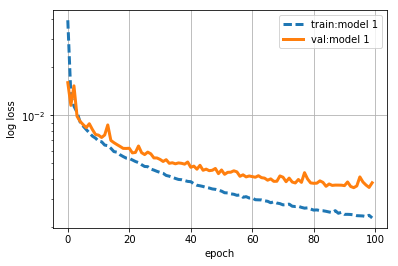

In [6]:
plot_loss(hist.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

##  Test data evaluation and visualization

In [7]:
X_test , _ = load(test=True)
y_test = model.predict(X_test)

     index     0
0  ImageId  1783
1    Image  1783


The simple feedfoward network shows some descent performance. but sometimes landmarks are off the face!

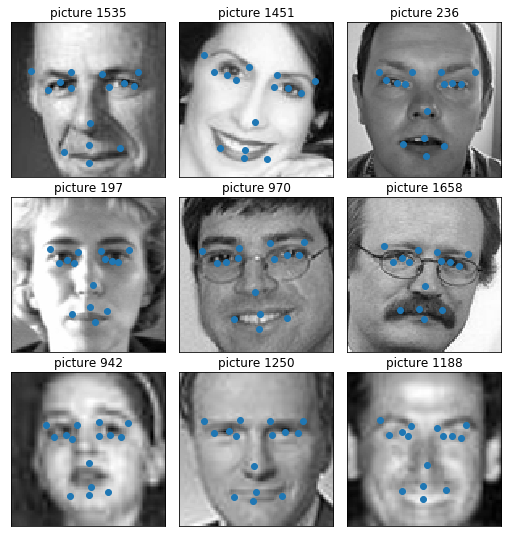

In [10]:
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_test[ipic],ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()

Save model weights and architecture

In [11]:
from keras.models import model_from_json

def save_model(model,name):
    '''
    save model architecture and model weights
    '''
    json_string = model.to_json()
    open(name+'_architecture.json', 'w').write(json_string)
    model.save_weights(name+'_weights.h5')
    
def load_model(name):
    model = model_from_json(open(name+'_architecture.json').read())
    model.load_weights(name + '_weights.h5')
    return(model)

save_model(model,"model1")
model = load_model("model1")

Delete these data as we use differently structured data from now on

In [12]:
del X, y, X_test, y_test

## Covolusional neural network
Let's make our model more complecated.
Loading training data. Notice that X is now 4-d numpy array (Nsample, Nrow, Ncol, 1).

In [13]:
## load data
X, y = load2d()
X.shape

                        index     0
0           left_eye_center_x  7039
1           left_eye_center_y  7039
2          right_eye_center_x  7036
3          right_eye_center_y  7036
4     left_eye_inner_corner_x  2271
5     left_eye_inner_corner_y  2271
6     left_eye_outer_corner_x  2267
7     left_eye_outer_corner_y  2267
8    right_eye_inner_corner_x  2268
9    right_eye_inner_corner_y  2268
10   right_eye_outer_corner_x  2268
11   right_eye_outer_corner_y  2268
12   left_eyebrow_inner_end_x  2270
13   left_eyebrow_inner_end_y  2270
14   left_eyebrow_outer_end_x  2225
15   left_eyebrow_outer_end_y  2225
16  right_eyebrow_inner_end_x  2270
17  right_eyebrow_inner_end_y  2270
18  right_eyebrow_outer_end_x  2236
19  right_eyebrow_outer_end_y  2236
20                 nose_tip_x  7049
21                 nose_tip_y  7049
22        mouth_left_corner_x  2269
23        mouth_left_corner_y  2269
24       mouth_right_corner_x  2270
25       mouth_right_corner_y  2270
26     mouth_center_top_lip_

(2140, 96, 96, 1)

Define simple CNN funciton as this model will be constructed several times

In [40]:
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout

def SimpleCNN(withDropout=False):
    '''
    WithDropout: If True, then dropout regularlization is added.
    This feature is experimented later.
    '''
    model = Sequential()
    model.add(Conv2D(32,(3, 3), input_shape = (96, 96, 1)))
    model.add(Activation('relu')) ## 96 - 3 + 2
    model.add(MaxPooling2D(pool_size = (2,2))) ## 96 - (3-1)*2
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu')) ## 
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(30))
    sgd = SGD(lr=0.01,momentum = 0.9,nesterov=True)
    model.compile(loss="mean_squared_error",optimizer=sgd)
    return(model)

In [15]:
%%time
model2 = SimpleCNN()

hist2 = model2.fit(X,y,nb_epoch=1000,validation_split=0.2,verbose=False)

CPU times: user 13min 3s, sys: 1min 28s, total: 14min 31s
Wall time: 10min 52s


## plot validation loss, train loss

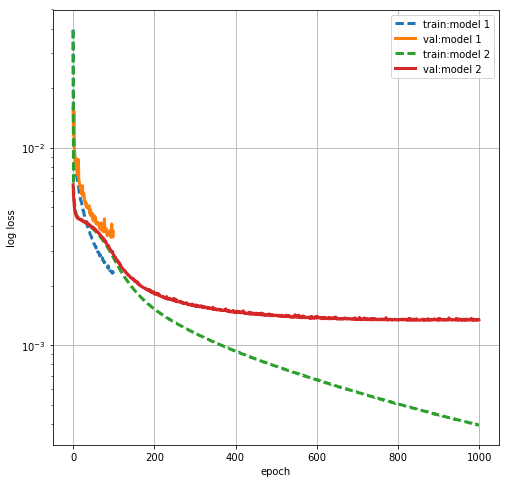

In [16]:
plt.figure(figsize=(8,8))
plot_loss(hist.history,"model 1",plt)
plot_loss(hist2.history,"model 2",plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [17]:
sample1,_ = load(test=True)
sample2,_ = load2d(test=True)
y_pred1 = model.predict(sample1)
y_pred2 = model2.predict(sample2)

     index     0
0  ImageId  1783
1    Image  1783
     index     0
0  ImageId  1783
1    Image  1783


Compare the model performance fully connected layers vs simple CNN

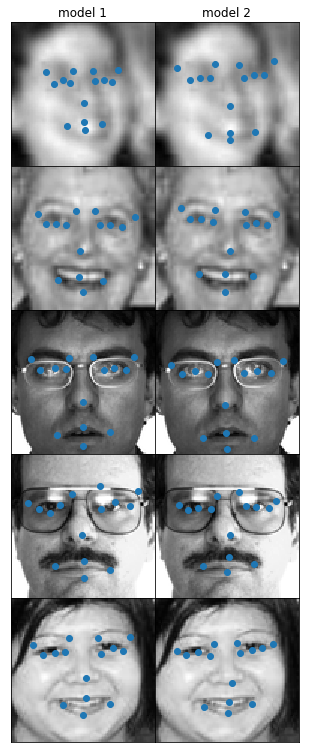

In [18]:

fig = plt.figure(figsize=(4, 10))
fig.subplots_adjust(hspace=0.001,wspace=0.001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 5
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(sample2.shape[0])
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])        
    plot_sample(sample1[ipic],y_pred1[ipic],ax)
    if count < 3:
        ax.set_title("model 1")
        
    count += 1
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])  
    plot_sample(sample2[ipic],y_pred2[ipic],ax)
    if count < 3:
        ax.set_title("model 2")
    count += 1
plt.show()


## Data augmentation
### flipping pictures
FlippedImageDataGenerator is written by [Shinya](https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html). This class extends the keras.preprocessing.image.mageDataGenerator and overwrites "next" method.
When I try using this class, it was not correctly generating flipped pictures. *This could be because of the different version of the keras? It seems ImageDataGenerator.flow() is not internally calling next() method). So I take more manual approach and explicitly write codes to modify each batch within each iteration/epoch (just as in [the first example of keras documentation](https://keras.io/preprocessing/image/)).

### Why not just using ImageDataGenerator? 
Keras has exisiting [ImageDataGenerator](https://keras.io/preprocessing/image/) but this only flip the data and not the land marks. I guess ImageDataGenerator can be used for image classification purpose where the classification labels do not need to be flipped. (e.g., Dog picture is a dog picture even if the picutre is flipped.)

In [19]:
class DataModifier(object):
    def fit(self,X_,y_):
        return(NotImplementedError)
    
class FlipPic(DataModifier):
    def __init__(self,flip_indices=None):
        if flip_indices is None:
            flip_indices = [
                (0, 2), (1, 3),
                (4, 8), (5, 9), (6, 10), (7, 11),
                (12, 16), (13, 17), (14, 18), (15, 19),
                (22, 24), (23, 25)
                ]
        
        self.flip_indices = flip_indices
        
    def fit(self,X_batch,y_batch):

        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)

        X_batch[indices] = X_batch[indices, :, ::-1,:]
        y_batch[indices, ::2] = y_batch[indices, ::2] * -1

        # flip left eye to right eye, left mouth to right mouth and so on .. 
        for a, b in self.flip_indices:
            y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )
        return X_batch, y_batch
    
    

manually splitting training and validation data

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(1712, 96, 96, 1)


Make sure that the pictures show up in both directions

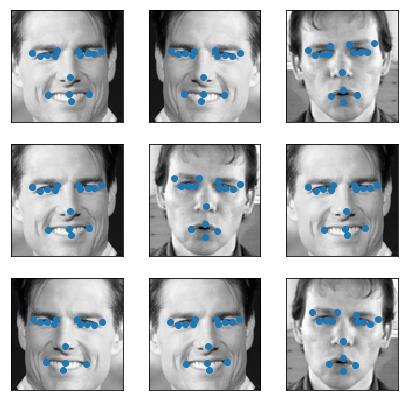

In [21]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator()
modifier = FlipPic()

fig = plt.figure(figsize=(7,7))

count = 1
for batch in generator.flow(X_train[:2],y_train[:2]):
    X_batch, y_batch = modifier.fit(*batch)

    ax = fig.add_subplot(3,3, count,xticks=[],yticks=[])  
    plot_sample(X_batch[0],y_batch[0],ax)
    count += 1
    if count == 10:
        break
plt.show()

## training
As previously discussed, we manually write fit function. 
Our fit function allows "Early stopping", which means that the back propagration algorithm will terminate if the validation loss does not decrease for <patience> conseqtive epochs

In [22]:


def fit(model,modifier,train,validation,
        batch_size=32,epochs=2000,print_every=10,patience=np.Inf):
    '''
    model :        keras model object
    Modifier:      DataModifier() object
    train:         tuple containing two numpy arrays (X_train,y_train)
    validation:    tuple containing two numpy arrays (X_val,y_val)
    patience:      The back propagation algorithm will stop if the val_loss does not decrease 
                   after <patience> epochs
    '''
    
    ## manually write fit method
    X_train,y_train = train
    X_val, y_val    = validation
    
    generator = ImageDataGenerator()
    
    history = {"loss":[],"val_loss":[]}
    for e in range(epochs):
        if e % print_every == 0:
            print('Epoch {:4}:'.format(e)), 
        ## -------- ##
        ## training
        ## -------- ##
        batches = 0
        loss_epoch = []
        for X_batch, y_batch in generator.flow(X_train, y_train, batch_size=batch_size):
            X_batch, y_batch = modifier.fit(X_batch, y_batch)
            hist = model.fit(X_batch, y_batch,verbose=False,epochs=1)
            loss_epoch.extend(hist.history["loss"])
            batches += 1
            if batches >= len(X_train) / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break   
        loss = np.mean(loss_epoch)
        history["loss"].append(loss)
        ## --------- ##
        ## validation
        ## --------- ##
        y_pred = model.predict(X_val)
        val_loss = np.mean((y_pred - y_val)**2)
        history["val_loss"].append(val_loss)
        if e % print_every == 0:
            print("loss - {:6.5f}, val_loss - {:6.5f}".format(loss,val_loss))
        min_val_loss = np.min(history["val_loss"])
        ## Early stopping
        if patience is not np.Inf:
            if np.all(min_val_loss < np.array(history["val_loss"])[-patience:]):
                break
    return(history)

In [23]:
%%time
#X, y = load2d()
model3 = SimpleCNN()
hist3 = fit(model3,modifier,
           train=(X_train,y_train),
           validation=(X_val,y_val),
           batch_size=32,epochs=2000,print_every=100
           )

Epoch    0: loss - 0.03308, val_loss - 0.00749
Epoch  100: loss - 0.00289, val_loss - 0.00274
Epoch  200: loss - 0.00174, val_loss - 0.00176
Epoch  300: loss - 0.00141, val_loss - 0.00152
Epoch  400: loss - 0.00120, val_loss - 0.00139
Epoch  500: loss - 0.00106, val_loss - 0.00131
Epoch  600: loss - 0.00097, val_loss - 0.00125
Epoch  700: loss - 0.00087, val_loss - 0.00122
Epoch  800: loss - 0.00080, val_loss - 0.00118
Epoch  900: loss - 0.00074, val_loss - 0.00114
Epoch 1000: loss - 0.00068, val_loss - 0.00113
Epoch 1100: loss - 0.00063, val_loss - 0.00110
Epoch 1200: loss - 0.00059, val_loss - 0.00109
Epoch 1300: loss - 0.00055, val_loss - 0.00108
Epoch 1400: loss - 0.00052, val_loss - 0.00107
Epoch 1500: loss - 0.00048, val_loss - 0.00107
Epoch 1600: loss - 0.00046, val_loss - 0.00106
Epoch 1700: loss - 0.00043, val_loss - 0.00106
Epoch 1800: loss - 0.00040, val_loss - 0.00106
Epoch 1900: loss - 0.00038, val_loss - 0.00106
CPU times: user 26min 35s, sys: 2min 40s, total: 29min 16s
W

## plot the training and validation losses
Data augmentation with flipped pictures help improving the model prediction accuracy.

One potential issue: "train:model 3" (final value: 0.00038) is by far less than the "val:model 3" (final value: 0.00106), indicating that the model might have overfitted.


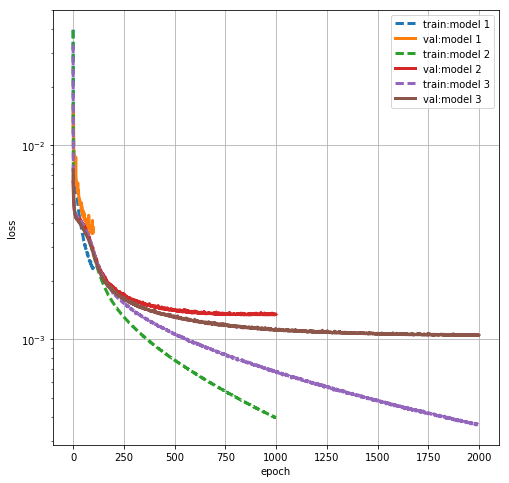

In [24]:
plt.figure(figsize=(8,8))
plot_loss(hist.history,"model 1",plt)
plot_loss(hist2.history,"model 2",plt)
plot_loss(hist3,"model 3",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

## data augmentation 
### shifting pictures
Flipping pictures can double the number of pictures twice. 
If we allow the pictures to shift by some pixcels within frames, this can increase the number of pictures substantially!
Here is my code to randomly shift the pictures to left, right, top, bottom by prespecified proportion.

In [25]:

class ShiftFlipPic(FlipPic):
    def __init__(self,flip_indices=None,prop=0.1):
        super(ShiftFlipPic,self).__init__(flip_indices)
        self.prop = prop
        
    def fit(self,X,y):
        X, y = super(ShiftFlipPic,self).fit(X,y)
        X, y = self.shift_image(X,y,prop=self.prop)
        return(X,y)
    def random_shift(self,shift_range,n=96):
        '''
        :param shift_range: 
        The maximum number of columns/rows to shift
        :return: 
        keep(0):   minimum row/column index to keep
        keep(1):   maximum row/column index to keep
        assign(0): minimum row/column index to assign
        assign(1): maximum row/column index to assign
        shift:     amount to shift the landmark

        assign(1) - assign(0) == keep(1) - keep(0)
        '''
        shift = np.random.randint(-shift_range,
                                  shift_range)
        def shift_left(n,shift):
            shift = np.abs(shift)
            return(0,n - shift)
        def shift_right(n,shift):
            shift = np.abs(shift)
            return(shift,n)

        if shift < 0:
            keep = shift_left(n,shift) 
            assign = shift_right(n,shift)
        else:
            assign = shift_left(n,shift) ## less than 96
            keep = shift_right(n,shift)

        return((keep,  assign, shift))

    def shift_single_image(self,x_,y_,prop=0.1):
        '''
        :param x_: a single picture array (96, 96, 1)
        :param y_: 15 landmark locations 
                   [0::2] contains x axis values
                   [1::2] contains y axis values 
        :param prop: proportion of random horizontal and vertical shift
                     relative to the number of columns
                     e.g. prop = 0.1 then the picture is moved at least by 
                     0.1*96 = 8 columns/rows
        :return: 
        x_, y_
        '''
        w_shift_max = int(x_.shape[0] * prop)
        h_shift_max = int(x_.shape[1] * prop)

        w_keep,w_assign,w_shift = self.random_shift(w_shift_max)
        h_keep,h_assign,h_shift = self.random_shift(h_shift_max)

        x_[w_assign[0]:w_assign[1],
           h_assign[0]:h_assign[1],:] = x_[w_keep[0]:w_keep[1],
                                           h_keep[0]:h_keep[1],:]

        y_[0::2] = y_[0::2] - h_shift/float(x_.shape[0]/2.)
        y_[1::2] = y_[1::2] - w_shift/float(x_.shape[1]/2.)
        return(x_,y_)

    def shift_image(self,X,y,prop=0.1):
            ## This function may be modified to be more efficient e.g. get rid of loop?
            for irow in range(X.shape[0]):
                x_ = X[irow]
                y_ = y[irow]
                X[irow],y[irow] = self.shift_single_image(x_,y_,prop=prop)
            return(X,y)

Following codes plot the generated pictures.

Observations
- The landmarks are shiftting together with the picture frame.
- Notice that if you shift the pictures too much, then the landmarks go outside of the frame.
(For now we are going to ignore this potential problem.)

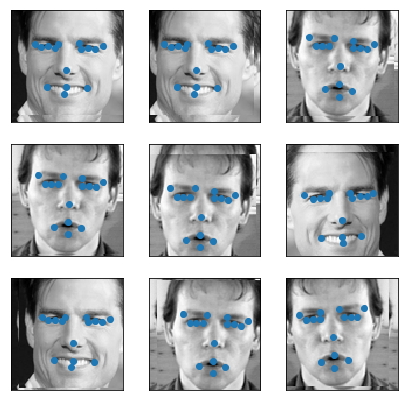

In [26]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator()
shiftFlipPic = ShiftFlipPic(prop=0.1)

fig = plt.figure(figsize=(7,7))

count = 1
for batch in generator.flow(X_train[:2],y_train[:2]):
    X_batch, y_batch = shiftFlipPic.fit(*batch)

    ax = fig.add_subplot(3,3, count,xticks=[],yticks=[])  
    plot_sample(X_batch[0],y_batch[0],ax)
    count += 1
    if count == 10:
        break
plt.show()


training

In [42]:
%%time
model4 = SimpleCNN()
hist4 = fit(model4,shiftFlipPic,
           train=(X_train,y_train),
           validation=(X_val,y_val),
           batch_size=32,epochs=3000,print_every=50,patience=100)

Epoch    0: loss - 0.04738, val_loss - 0.00727
Epoch   50: loss - 0.00461, val_loss - 0.00318
Epoch  100: loss - 0.00343, val_loss - 0.00225
Epoch  150: loss - 0.00293, val_loss - 0.00195
Epoch  200: loss - 0.00250, val_loss - 0.00177
Epoch  250: loss - 0.00230, val_loss - 0.00166
Epoch  300: loss - 0.00225, val_loss - 0.00155
Epoch  350: loss - 0.00213, val_loss - 0.00151
Epoch  400: loss - 0.00201, val_loss - 0.00142
Epoch  450: loss - 0.00192, val_loss - 0.00138
Epoch  500: loss - 0.00182, val_loss - 0.00134
Epoch  550: loss - 0.00173, val_loss - 0.00131
Epoch  600: loss - 0.00169, val_loss - 0.00131
Epoch  650: loss - 0.00166, val_loss - 0.00125
Epoch  700: loss - 0.00158, val_loss - 0.00123
Epoch  750: loss - 0.00154, val_loss - 0.00121
Epoch  800: loss - 0.00148, val_loss - 0.00117
Epoch  850: loss - 0.00147, val_loss - 0.00116
Epoch  900: loss - 0.00141, val_loss - 0.00113
Epoch  950: loss - 0.00137, val_loss - 0.00111
Epoch 1000: loss - 0.00136, val_loss - 0.00112
Epoch 1050: l

## plot the training and validation losses

Data augmentation with flipped + shifted pictures help improving the model prediction accuracy.
The val_loss is below 0.001

Model 3 had overfitting issue when the number of epoch was 2000 ("train:model 3" << "val:model 3").
Model 4 seems to have an opposite situation, underfitting, at epoch = 2000 as  ("train:model 4" > "val:model 4").
As "val: model4" seems still decreasing at epoch = 2000, we increase the number of epoch to 3000.
By epoch = 3000 "train:model 4" ~= "val:model 4". In practice, it is better to stop the training when training loss is slightly less than the validation, but I stop training here. 


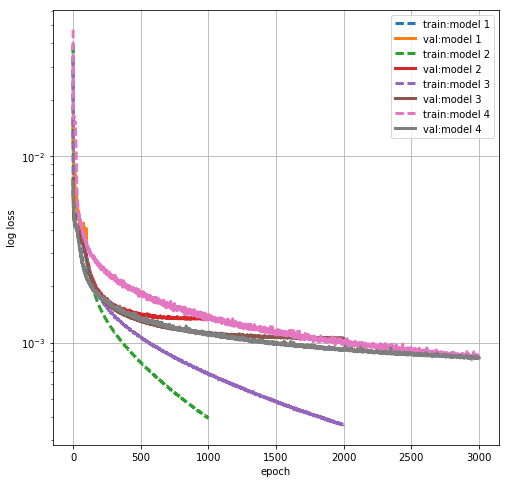

In [43]:
plt.figure(figsize=(8,8))
plot_loss(hist.history,"model 1",plt)
plot_loss(hist2.history,"model 2",plt)
plot_loss(hist3,"model 3",plt)
plot_loss(hist4,"model 4",plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Save the model object as model 4 seems to be the best so far

In [45]:
save_model(model4,"model4")

# More complex model
[Shinya's blog](https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html) also experimented with adding Dropout regulaziation layer. You can do this by setting model5 = SimpleCNN(True). 
As the data augmentation with the random shifting already served the purpose of raguralization, I did not see much improvement by adding Dropout layer. 

## Create separate models for different landmarks separately.
Up to this point, we are only using about 20% (X.shape[0] = 2140) of the original data. 
This is quite a waste as for some landmarks (e.g., left_eye_center, right_eye_center), more than 7000 frames are available. If I separately create model for separate set of landmarks, I can use more data for training.

This motivated [Danile Nouri](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) to create seprate models.
I follow this blog and create 6 separate models. The 15 landmarks are devided into 6 separate groups as shown in the list "SPECIALIST_SETTINGS" below. All 6 models contains the same CNN architecture but the final output layer is adjusted for different number of outputs: for example we have a model for left eye and right eye center landmark prediction. As there are are x and y coordinates for both eye centers, we have 4 nodes in the output layer of this model.

Remind you that it took me 38 minutes to train Model 4 with epochs = 3000.
If I train all 6 models from a scratch, it could take about 4 hours (38 minutes x 6). 
Instead, I will take advantage of the knowledge (i.e., weights) from model 4. 
We will use the weights from model 4 and only train the weights from the final output layer. 
This is the idea of transfer learning.

About 1000 epochs would be enough to train the weights from the final output layers. 
However, we will just train 500 epochs due to the lack of time.



In [194]:

SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

from collections import OrderedDict

def fit_specialists(freeze=True,
                    print_every=50,
                    epochs=3000,
                    prop=0.1,
                    name_transfer_model="model4"):
    specialists = OrderedDict()
 

    for setting in SPECIALIST_SETTINGS:
        
        cols = setting['columns']
        flip_indices = setting['flip_indices']
        
        X, y = load2d(cols=cols)
        X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
        model = load_model(name_transfer_model) 
        if freeze:
            for layer in model.layers:
                layer.trainable = False
            
        model.layers.pop() # get rid of output layer
        model.outputs = [model.layers[-1].output]
        model.layers[-1].outbound_nodes = []
        model.add(Dense(len(cols))) # add new output layer

        model.compile(loss='mean_squared_error', optimizer="adam")
        
        shiftFlipPic = ShiftFlipPic(flip_indices=flip_indices,
                                    prop=prop)
        
        ## print(model.summary())
        hist = fit(model,shiftFlipPic,
                    train=(X_train,y_train),
                    validation=(X_val,y_val),
                    batch_size=32,epochs=epochs,
                    print_every=print_every) 
        
       
        specialists[cols] = {"model":model,
                             "hist":hist}
    return(specialists)


- Set freeze = True for training the weights only from the final outputlayers. If freeze = False then the weights from the transfer model are used only for the initialization of the model and all the weights are re-trained.
- epochs = 500 seems to be enough (checked by looking at the plot of val_loss vs epochs)
- use model4 as the transfer model

In [47]:
%%time
specialists1 = fit_specialists(freeze=True,
                    print_every=50,
                    epochs=500,
                    name_transfer_model="model4")

                index     0
0   left_eye_center_x  7039
1   left_eye_center_y  7039
2  right_eye_center_x  7036
3  right_eye_center_y  7036
4               Image  7049
Epoch    0: loss - 0.01192, val_loss - 0.00540
Epoch   50: loss - 0.00252, val_loss - 0.00319
Epoch  100: loss - 0.00250, val_loss - 0.00319
Epoch  150: loss - 0.00260, val_loss - 0.00313
Epoch  200: loss - 0.00260, val_loss - 0.00309
Epoch  250: loss - 0.00261, val_loss - 0.00317
Epoch  300: loss - 0.00254, val_loss - 0.00311
Epoch  350: loss - 0.00253, val_loss - 0.00312
Epoch  400: loss - 0.00249, val_loss - 0.00310
Epoch  450: loss - 0.00258, val_loss - 0.00335
        index     0
0  nose_tip_x  7049
1  nose_tip_y  7049
2       Image  7049
Epoch    0: loss - 0.01236, val_loss - 0.00851
Epoch   50: loss - 0.00565, val_loss - 0.00483
Epoch  100: loss - 0.00573, val_loss - 0.00476
Epoch  150: loss - 0.00557, val_loss - 0.00490
Epoch  200: loss - 0.00575, val_loss - 0.00469
Epoch  250: loss - 0.00563, val_loss - 0.00466


### plot validation losses of each specialist model

You might think that the model performance is relatively poor especially for the nose tip models, and month center models, because their losses are above 0.03.
However, you should not compare these validation losses with the validation losses from model 4, because the data size has increased almost 4 times for these data.




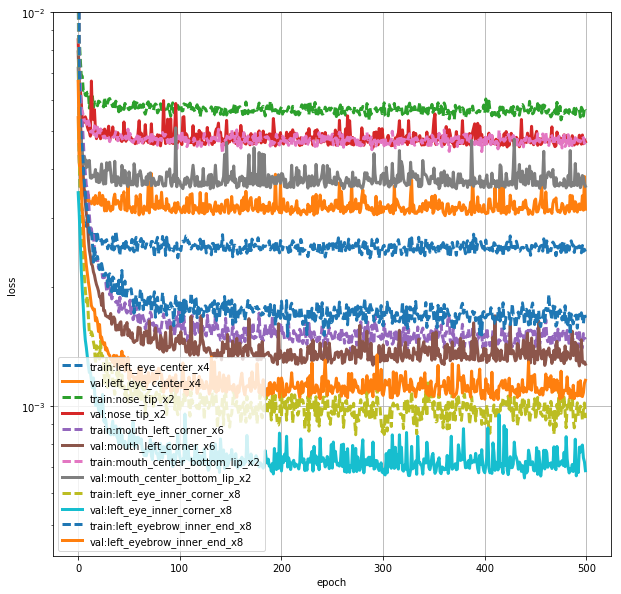

In [218]:

def plot_specialist(specialists1,plt):
    
    i = 1
    for key , value in specialists1.items():
        plot_loss(value["hist"],key[0] + str(len(key)),plt)
        i += 1

    plt.legend()
    plt.grid()
    plt.set_yscale("log")
    plt.set_xlabel("epoch")
    plt.set_ylabel("loss")
  
fig = plt.figure(figsize=(10,10))  
ax = fig.add_subplot(1,1,1)
ax.set_ylim(7**(-4),10**(-2))
plot_specialist(specialists1,ax)
plt.show()

### Where do I stand in the kaggle competition?
We predict the landmarks of testing set, using model4 and specialist model.

In [201]:
from pandas import DataFrame, concat

X_test,_ = load2d(test=True)

## prediction with model 4
y_pred4 = model4.predict(X_test)
landmark_nm = read_csv(os.path.expanduser(FTRAIN)).columns[:-1].values
df_y_pred4 = DataFrame(y_pred4,columns = landmark_nm)

## prediction with specialist model
def predict_specialist(specialists1,X_test):
    y_pred_s = []
    for columns, value in specialists1.items():
        smodel = value["model"]

        y_pred = smodel.predict(X_test)
        y_pred = DataFrame(y_pred,columns=columns)
        y_pred_s.append(y_pred)

    df_y_pred_s = concat(y_pred_s,axis=1)
    return(df_y_pred_s)
df_y_pred_s = predict_specialist(specialists1,X_test)
y_pred_s = df_y_pred_s.values

     index     0
0  ImageId  1783
1    Image  1783


Create .csv files to submit to keggle (Late submission)

In [143]:
IdLookup = read_csv(os.path.expanduser(FIdLookup))

def prepare_submission(y_pred4,filename):
    '''
    save a .csv file that can be submitted to kaggle
    '''
    ImageId = IdLookup["ImageId"]
    FeatureName = IdLookup["FeatureName"]
    RowId = IdLookup["RowId"]
    
    submit = []
    for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
        submit.append([rowId,y_pred4[landmark].iloc[irow-1]])
    
    submit = DataFrame(submit,columns=["RowId","Location"])
    ## adjust the scale 
    submit["Location"] = submit["Location"]*48 + 48
    print(submit.shape)
    loc = "result/" + filename + ".csv"
    submit.to_csv(loc,index=False)
    print("File is saved at:" +  loc)
    
prepare_submission(df_y_pred4,"model4")
prepare_submission(df_y_pred_s,"special")

(27124, 2)
File is saved at:result/model4.csv
(27124, 2)
File is saved at:result/special.csv


### kaggle Results


- model4 scores 2.86 (Private score) and 2.93 (Public score)
- special scores 2.26819 (Private score) and 2.53439 (Public score)

This means that the special model rank top 50 out of 175 teams. i.e., top 30%! at 2018, January 4th.


In [175]:
## reorder the columns of df_y_pred_s
df_y_pred_s = df_y_pred_s[df_y_pred4.columns]
df_compare = {}
df_compare["difference"] = ((df_y_pred_s - df_y_pred4)**2).mean(axis=1)
df_compare["RowId"] = range(df_y_pred_s.shape[0])
df_compare = DataFrame(df_compare)
df_compare = df_compare.sort_values("difference",ascending=False)



Intuitively, when landmarks are harder to detect, the two model performances are different.
Therefore it makes sense to learn about the frames where the two models detections are similar/desimilar.

Plot the model performance of the best 13 and worst 13 pictures.

- "best" - The two model results agree the most.
- "worst" - The two model results disgree the most.

 

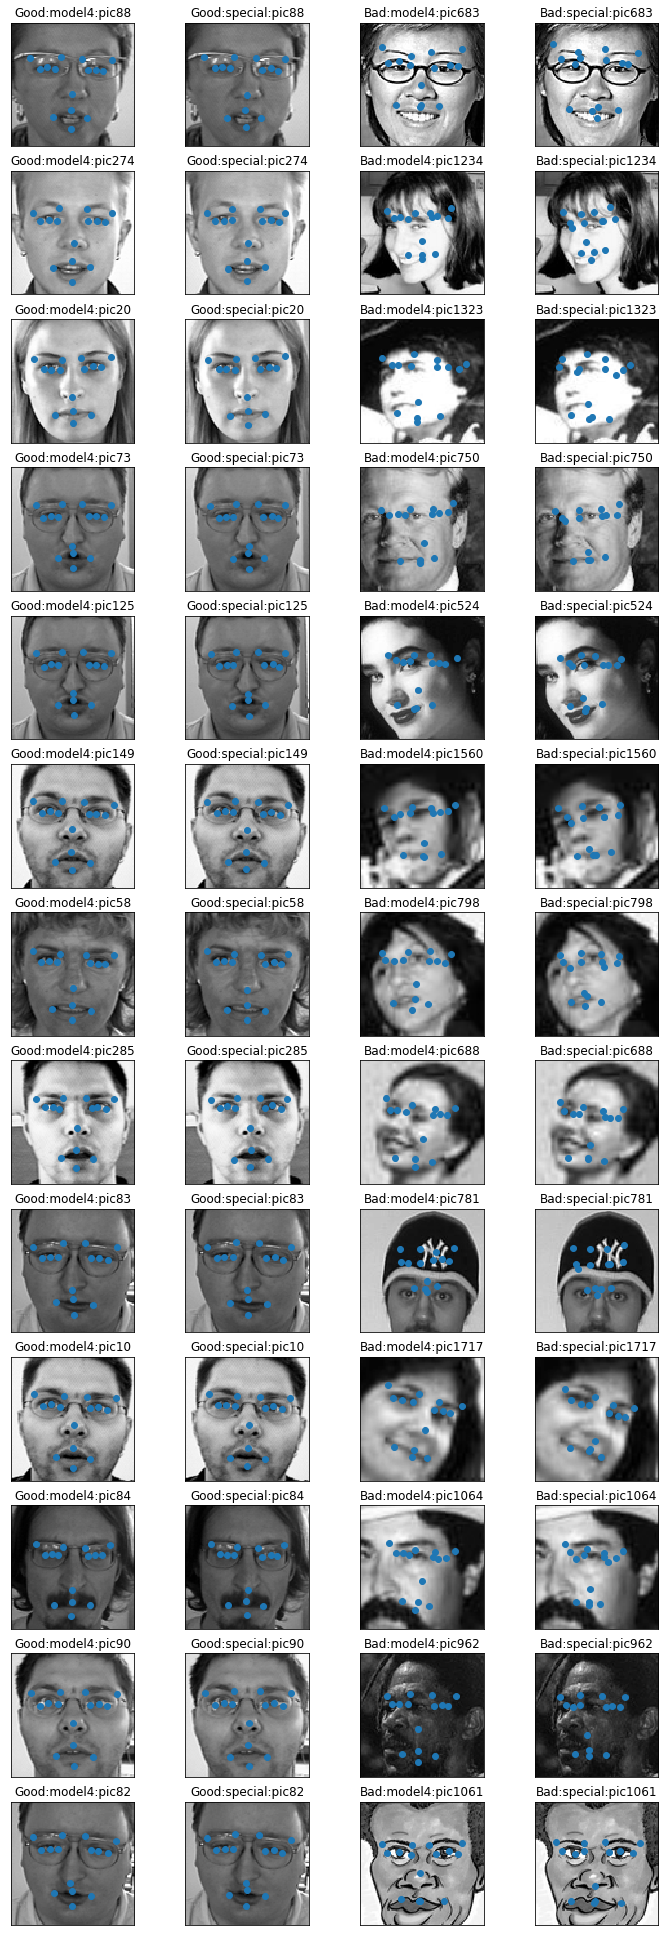

In [192]:
fig = plt.figure(figsize=(12,35))

Nsample = 13
pic_index = df_compare["RowId"].iloc[:Nsample].values
pic_index_good = df_compare["RowId"].iloc[-Nsample:].values
count = 1


for ipic_g,ipic in zip(pic_index_good,pic_index):
    ## bad model 4
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred4[ipic_g],ax)
    ax.set_title("Good:model4:pic"+str(ipic_g))
    
    ## bad special
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred_s[ipic_g],ax)
    ax.set_title("Good:special:pic"+str(ipic_g))
    
    ## bad model 4
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred4[ipic],ax)
    ax.set_title("Bad:model4:pic"+str(ipic))
    
    ## bad special
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s[ipic],ax)
    ax.set_title("Bad:special:pic"+str(ipic))

plt.show()


## Specialist model revisited

From the plots above, it is clear that the model performances are good when the faces are located at the center and facing front. The model performances are poor when the faces are looking side or not at the center.

So the next step to improve the model prediction performance would be to
- 1: increase the shifting proportion (to improve the model performance of pic750)
- 2: use the weights from the transfer model only as the initial weights and re-train all the weights. 
- 3: augment the data to include more data 
    - with different shear angle (to improve the model performance of pic1234 or pic962)
    - with different zooming (to improve the model performance of pic1064)

We will only conider the 1st and 2nd points.

Unexpectedly, we actually do not need too many epochs for the model to converge even when the weights are not frozen! 

In [198]:

%%time
specialists2 = fit_specialists(freeze=False,
                    print_every=50,
                    epochs=300,
                    prop=0.2,
                    name_transfer_model="model4")

                index     0
0   left_eye_center_x  7039
1   left_eye_center_y  7039
2  right_eye_center_x  7036
3  right_eye_center_y  7036
4               Image  7049
Epoch    0: loss - 0.05922, val_loss - 0.00636
Epoch   50: loss - 0.00197, val_loss - 0.00240
Epoch  100: loss - 0.00178, val_loss - 0.00312
Epoch  150: loss - 0.00123, val_loss - 0.00299
Epoch  200: loss - 0.00125, val_loss - 0.00262
Epoch  250: loss - 0.00105, val_loss - 0.00263
        index     0
0  nose_tip_x  7049
1  nose_tip_y  7049
2       Image  7049
Epoch    0: loss - 0.08784, val_loss - 0.01316
Epoch   50: loss - 0.00389, val_loss - 0.00341
Epoch  100: loss - 0.00291, val_loss - 0.00262
Epoch  150: loss - 0.00264, val_loss - 0.00270
Epoch  200: loss - 0.00229, val_loss - 0.00236
Epoch  250: loss - 0.00219, val_loss - 0.00223
                    index     0
0     mouth_left_corner_x  2269
1     mouth_left_corner_y  2269
2    mouth_right_corner_x  2270
3    mouth_right_corner_y  2270
4  mouth_center_top_lip_x  2

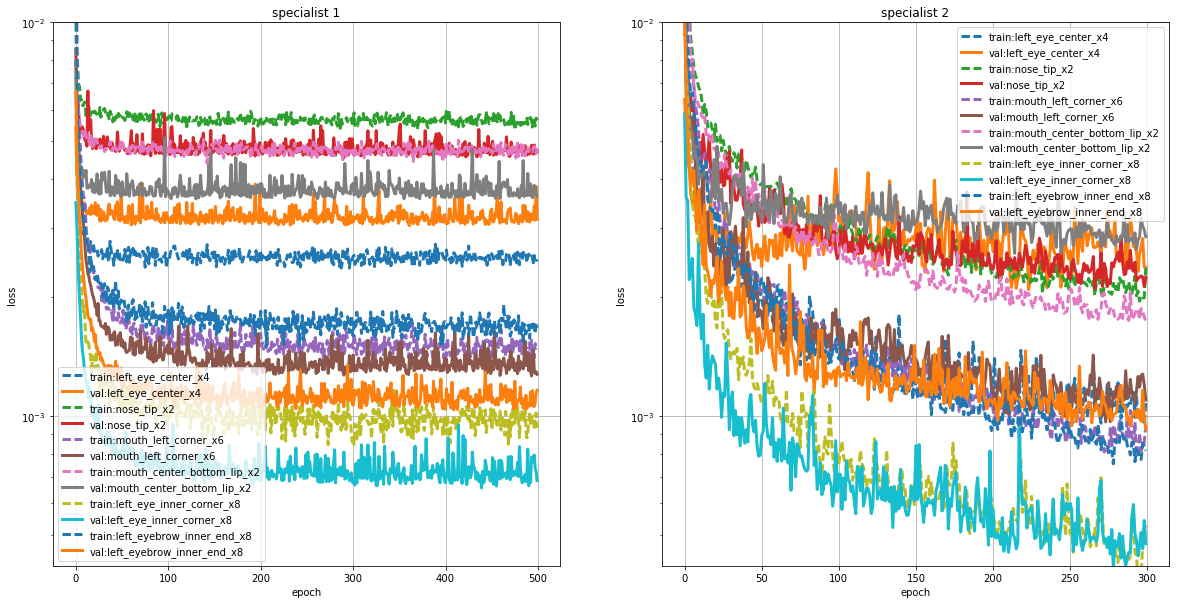

In [222]:

ylim = (7**(-4),10**(-2))
fig = plt.figure(figsize=(20,10))  

ax = fig.add_subplot(1,2,1)
ax.set_ylim(ylim)
ax.set_title("specialist 1")
plot_specialist(specialists1,ax)

ax = fig.add_subplot(1,2,2)
ax.set_ylim(ylim)
ax.set_title("specialist 2")
plot_specialist(specialists2,ax)

plt.show()

## Kaggle results
I am proud to say that this specialist model 2 achieves: 
- private score 1.71181 
- public score 2.04064
- top 40 out of 175 teams (_top 23%_)

Pretty good!

In [223]:
df_y_pred_s2 = predict_specialist(specialists2,X_test)
prepare_submission(df_y_pred_s2,"special2")

(27124, 2)
File is saved at:result/special2.csv


finally I look at the model performances of specialist 2 in the worst performing 23 pictures as before.
Notice that the model performance of the pic 750, pic 962 and many others with off-the-center faces substantially improved.

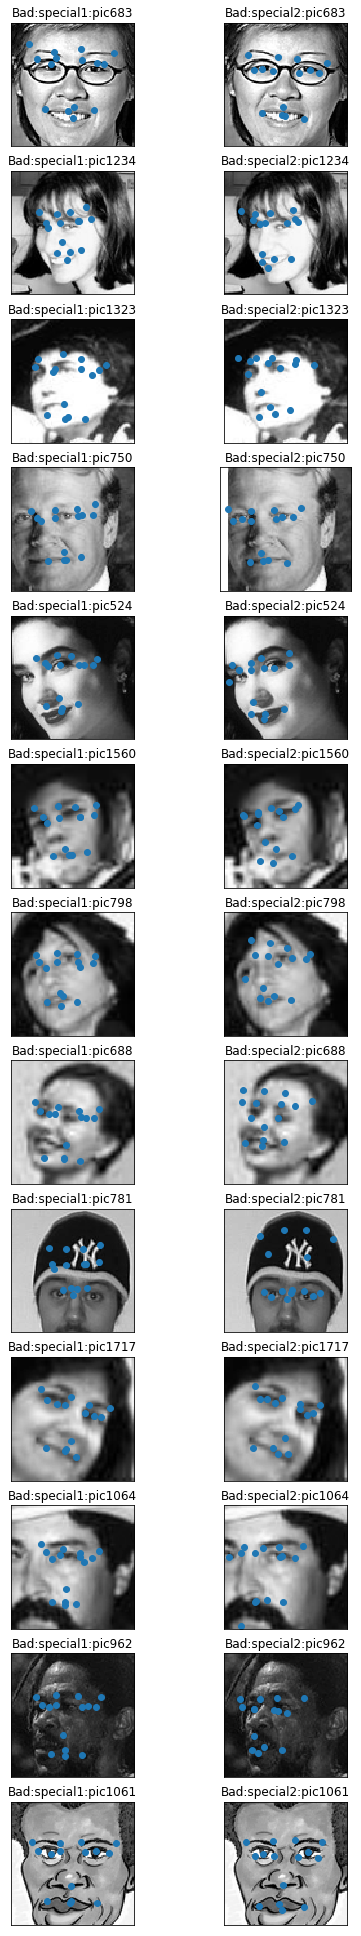

In [233]:
fig = plt.figure(figsize=(7,35))
y_pred_s2 = df_y_pred_s2.values
Nsample = 13
pic_index = df_compare["RowId"].iloc[:Nsample].values
pic_index_good = df_compare["RowId"].iloc[-Nsample:].values
count = 1


for ipic_g,ipic in zip(pic_index_good,pic_index):

    ax = fig.add_subplot(Nsample,2,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s[ipic],ax)
    ax.set_title("Bad:special1:pic"+str(ipic))
    
    ax = fig.add_subplot(Nsample,2,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s2[ipic],ax)
    ax.set_title("Bad:special2:pic"+str(ipic))
    
    

    
   
plt.show()